# Cleaning yield monitor data & obtain management zones

#### Final Project AGRON 845 - Spring 2024
#### Student: Emmanuela van Versendaal

## Physical meaning method

### Introduction & Objectives


Yield monitor data allows farmers to measure variability within the field over time and space, providing them with the chance to apply crop inputs precisely when and where they are necessary. However, yield monitor data often contains errors caused by the harvesting equipment. Therefore, it is crucial to identify this erroneous data and clean the yield monitor datasets to obtain the most accurate maps possible (Khosla and Flynn, 2008). With high-quality yield maps, management zones can be established within the field. These management zone maps are essential for implementing variable input rates across the field, thereby enhancing crop yields, reducing costs, and preventing environmental contamination (Bullock et al., 2002).

The aim of this project is to develop a workflow to clean yield monitor data and delineate management zones within a farm.

### 1. Import modules

In [2]:
# Import modules
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

## Create grid
from shapely.geometry import box

## CLustering using K-Means
from sklearn.cluster import KMeans
from scipy.interpolate import griddata

### 2. Import the data

#### 2.1. Import the dataset
Import the yield monitor shapefile documents

In [3]:
df = gpd.read_file('../1_Data/shp_farm/Corn_2017.shp')
#df.to_crs(epsg=4326)
df.head(3)

,DISTANCE,SWATHWIDTH,VRYIELDVOL,SECTIONID,Crop,WetMass,Moisture,Time,Heading,VARIETY,Elevation,IsoTime,Machine,VEHICLSPEE,DRYMATTER,geometry
0,4.055719,20.0,234.0,138,173,13416.410144,16.87,10/21/2017 1:33:44 PM,90.109047,P0589AM,664.636987,2017-10-21T13:33:44.405Z,1,2.759743,83.13,POINT (-87.90551 40.58310)
1,4.055719,20.0,230.0,138,173,13140.843137,16.87,10/21/2017 1:33:45 PM,89.859047,P0589AM,664.594336,2017-10-21T13:33:45.405Z,1,2.765263,83.13,POINT (-87.90549 40.58310)
2,4.088527,20.0,197.0,138,173,11280.964940,16.87,10/21/2017 1:33:46 PM,89.729047,P0589AM,664.597617,2017-10-21T13:33:46.406Z,1,2.784847,83.13,POINT (-87.90548 40.58310)


#### 2.2. Data wrangling and checking

In [6]:
df['VRYIELDVOL'] = df['VRYIELDVOL'].round(0)

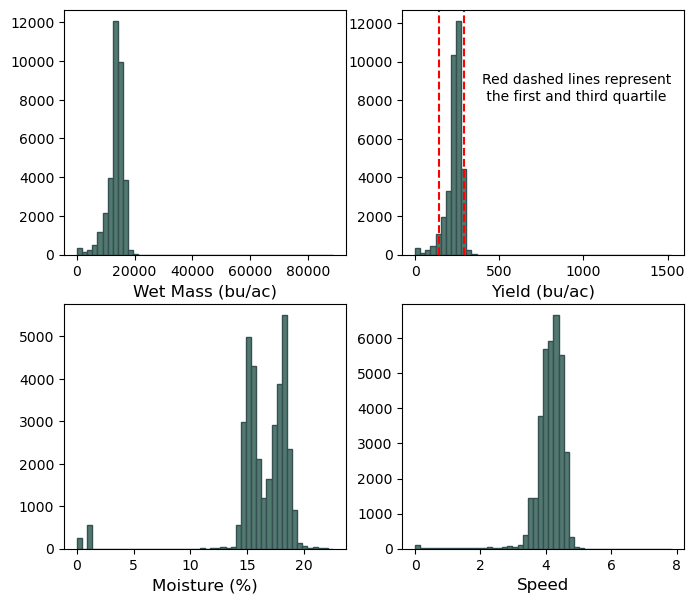

In [7]:
## plot some variables to check ##
edgecolor = '#354f52'
color = "#52796f"
bins = 50

plt.figure(figsize=(8,7))

plt.subplot(2,2,1)
plt.hist(df["WetMass"], edgecolor = edgecolor, color = color, bins = bins)
plt.xlabel("Wet Mass (bu/ac)", size=12)


plt.subplot(2,2,2)
plt.hist(df["VRYIELDVOL"], edgecolor = edgecolor, color = color, bins = bins)
plt.axvline(df["VRYIELDVOL"].quantile(0.05),
            color='red', linestyle = '--')
plt.axvline(df["VRYIELDVOL"].quantile(0.95),
            color='red',linestyle = '--')
plt.xlabel("Yield (bu/ac)", size=12)
plt.annotate('Red dashed lines represent \n the first and third quartile', xy = (400,8000))

plt.subplot(2,2,3)
plt.hist(df["Moisture"], edgecolor = edgecolor, color = color, bins = bins)
plt.xlabel("Moisture (%)", size=12)

plt.subplot(2,2,4)
plt.hist(df["VEHICLSPEE"], edgecolor = edgecolor, color = color, bins = bins)
plt.xlabel("Speed", size=12)

plt.show()

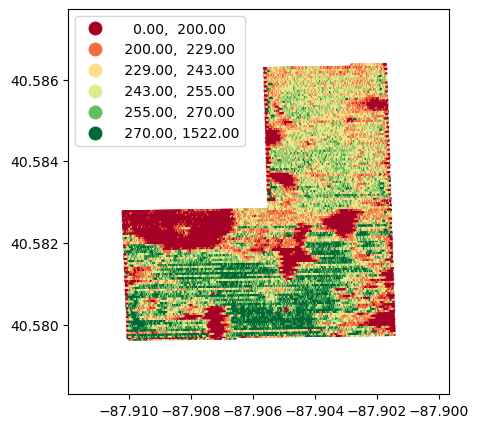

In [4]:
## Plot the yield map ##
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.ticklabel_format(useOffset=False)

# Set margins (to have more space between the map and axis)
ax.set_xmargin(0.2)  
ax.set_ymargin(0.2) 

# Map settings
original_yield_map = df.plot(ax = ax,
                             figsize = (7, 7),
                             column = 'VRYIELDVOL',
                             scheme = 'Quantiles',
                             k = 6,
                             cmap = 'RdYlGn', #df['VRYIELDVOL'].min(), vmax=df['VRYIELDVOL'].max(),
                             legend = True,
                             marker = '.', 
                             markersize =3.5,
                             legend_kwds={'loc': 'upper left'}) 

### 3. Clean the maps: 

Filtering rules with clear physical meaning

In [9]:
## Filtering rules ##
idx_too_slow = df["VEHICLSPEE"] < 2.5
idx_too_fast = df["VEHICLSPEE"] > 6
idx_too_wet = df["Moisture"] > 20
idx_too_dry = df["Moisture"] < 10
idx_high_yield = df["VRYIELDVOL"] >= df["VRYIELDVOL"].quantile(0.975) # In my particular case, I want to mantain as much as possible the extreme values
idx_low_yield = df["VRYIELDVOL"] <= df["VRYIELDVOL"].quantile(0.025)
#idx_low_flow = df["Flow"] <= 10 # My yield monitor data did not contain flow
#idx_high_flow = df["Flow"] >= 18

## Create index with all the filtering rules ##
idx = idx_too_slow | idx_too_fast | idx_too_dry | idx_too_wet | idx_high_yield | idx_low_yield

## obtain outliers ##

df_out = df[idx]

## Clean the the values ##
df_clean = df[~idx]

In [10]:
print(df.shape)
print(df_clean.shape)
removed_points = df.shape[0] - df_clean.shape[0]
print("Removed",str(removed_points),'points')

(34672, 16)
(32213, 16)
Removed 2459 points


<Axes: >

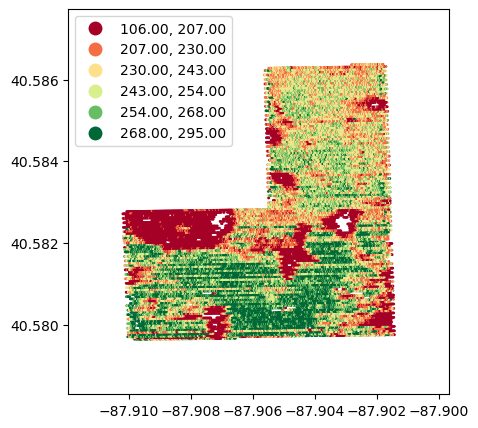

In [11]:
## Plot the yield map ##
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.ticklabel_format(useOffset=False)

# Set margins (to have more space between the map and axis)
ax.set_xmargin(0.2)  
ax.set_ymargin(0.2) 

# Map settings
df_clean.plot(ax = ax,
              figsize = (7, 7),
              column = 'VRYIELDVOL',
              scheme = 'Quantiles',
              k = 6,
              cmap = 'RdYlGn',  legend = True,
               marker = '.', markersize =3.5,
              legend_kwds={'loc': 'upper left'}) 

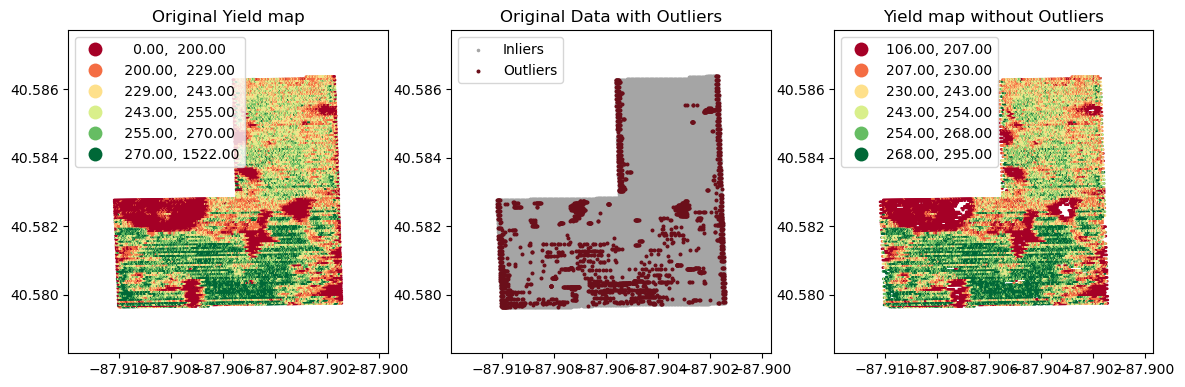

In [12]:
# Colors
original = '#a5a5a5'
out_col = '#6b0f1a'

# Create a figure and axes objects for two subplots
fig, (ax,ax1, ax2) = plt.subplots(1, 3, figsize=(14, 6))  # Adjust the figsize to fit your needs

## MAP 1  - original yield map##
ax.set_xmargin(0.2)
ax.set_ymargin(0.2)
df.plot(ax = ax,
        #figsize = (7, 7),
        column = 'VRYIELDVOL',
        scheme = 'Quantiles',
        k = 6,
        cmap = 'RdYlGn', legend = True,
        marker = '.', markersize=2.5,
        legend_kwds={'loc': 'upper left'}) 
ax.set_title("Original Yield map")


## MAP 2 ##
# Set margins (to have more space between the map and axis)
ax1.set_xmargin(0.2)
ax1.set_ymargin(0.2)

df.plot(ax=ax1, color=original, markersize=2.5, label='Inliers')
df_out.plot(ax=ax1, color=out_col, markersize=3.5, label='Outliers')
ax1.legend()
ax1.set_title("Original Data with Outliers")

## MAP 3 ##
# Set margins (to have more space between the map and axis)
ax2.set_xmargin(0.2)
ax2.set_ymargin(0.2)
df_clean.plot(ax = ax2,
              figsize = (7, 7),
              column = 'VRYIELDVOL',
              scheme = 'Quantiles',
              k = 6,
              cmap = 'RdYlGn',  legend = True,
               marker = '.', markersize =2.5,
              legend_kwds={'loc': 'upper left'}) 
ax2.set_title("Yield map without Outliers")

# Show the plot
plt.show()

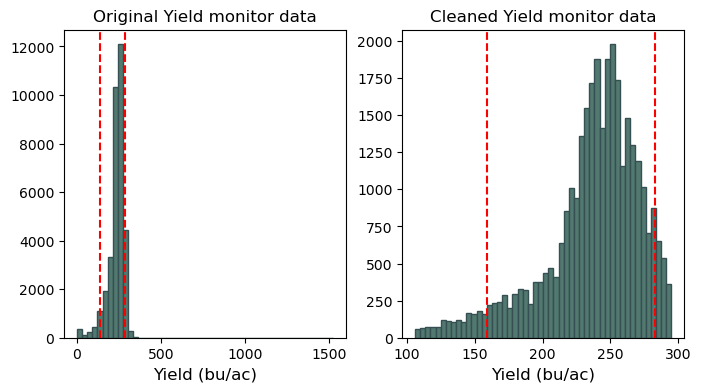

In [13]:
edgecolor = '#354f52'
color = "#52796f"
bins = 50

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.hist(df["VRYIELDVOL"], edgecolor = edgecolor, color = color, bins = bins)
plt.axvline(df["VRYIELDVOL"].quantile(0.05), color='red', linestyle = '--')
plt.axvline(df["VRYIELDVOL"].quantile(0.95), color='red', linestyle = '--')
plt.xlabel("Yield (bu/ac)", size=12)
plt.annotate('Red lines represent the \n first and third quartile', xy = (3500,8000))
plt.title('Original Yield monitor data')

plt.subplot(1,2,2)
plt.hist(df_clean["VRYIELDVOL"], edgecolor = edgecolor, color = color, bins = bins)
plt.axvline(df_clean["VRYIELDVOL"].quantile(0.05), color='red', linestyle = '--')
plt.axvline(df_clean["VRYIELDVOL"].quantile(0.95), color='red', linestyle = '--')
plt.xlabel("Yield (bu/ac)", size=12)
plt.title('Cleaned Yield monitor data')


plt.show()

#### 4.1. Define field boundary

In [14]:
# Read field boundaries
boundary = gpd.read_file('../1_Data/polygons/Polygon.shp')
#df.to_crs(epsg=4326)
boundary

,FID,geometry
0,0,"POLYGON ((-87.91019 40.58276, -87.90545 40.582..."


##### Creat grid map and clip cells

In [15]:
xmin, ymin, xmax, ymax = boundary.boundary.total_bounds

# Define cell size
xdelta = (xmax - xmin)/40
ydelta = (ymax - ymin)/40

# Create and empty array to save the grid
grid = np.array([])

for x in np.arange(xmin, xmax, xdelta):
    for y in np.arange(ymin, ymax, ydelta):
        cell = box(x, y, x+xdelta, y+ydelta)
        grid = np.append(grid, cell)
        
gdf_grid = gpd.GeoDataFrame(grid, columns=['geometry'], crs = df.crs)

# Clip cells
gdf_grid = gpd.clip(gdf_grid, boundary['geometry'])
gdf_grid.reset_index(inplace=True, drop=True)

##### Plot grid map

<Axes: >

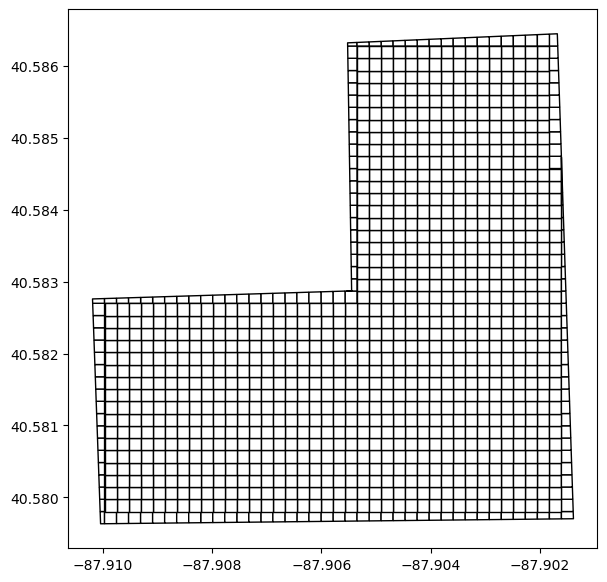

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))
ax.ticklabel_format(useOffset=False)

gdf_grid.plot(ax = ax, facecolor = 'w', edgecolor = 'k')

#### 4.2. Median yield

Iteration over each grid cell and compute median yield value.

In [17]:
M = []

for k, row in gdf_grid.iterrows():
    
    idx = (df_clean.geometry).within(row.geometry)
    
    val = df_clean.loc[idx, 'VRYIELDVOL'].median()
    M.append(val)
    
gdf_grid['yield'] = M 

In [18]:
df_clean = df_clean.dropna()
df_clean["VRYIELDVOL"].isna().sum()

0

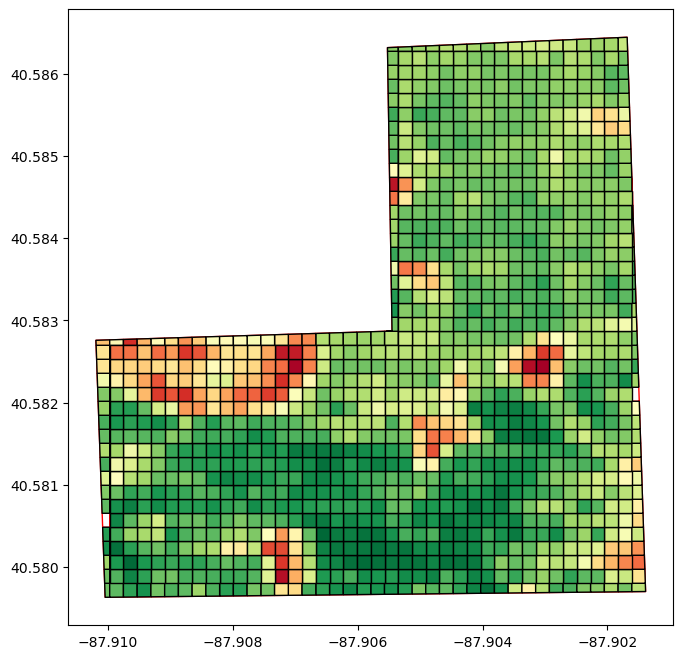

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.ticklabel_format(useOffset=False)

gdf_grid.plot(ax=ax, facecolor='w', edgecolor='red')
final_yield_map = gdf_grid.plot(ax=ax,column = 'yield', edgecolor = 'k', cmap = 'RdYlGn')

#fig.savefig('final_yield_map.png')

plt.show()

In [20]:
# CLustering using K-Means
gdf_grid.dropna(inplace=True)
kmeans_info = KMeans(n_clusters=3, n_init='auto').fit(gdf_grid['yield'].values.reshape(-1,1))
gdf_grid['zone'] = kmeans_info.labels_.flatten()
gdf_grid.head()

C:\Users\evanversendaal\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


,geometry,yield,zone
0,"POLYGON ((-87.91005 40.57980, -87.90997 40.579...",248.0,2
1,"POLYGON ((-87.90997 40.57963, -87.90997 40.579...",252.0,2
2,"POLYGON ((-87.90513 40.57967, -87.90513 40.579...",243.5,0
3,"POLYGON ((-87.90975 40.57964, -87.90975 40.579...",263.0,2
4,"POLYGON ((-87.90491 40.57968, -87.90491 40.579...",253.0,2


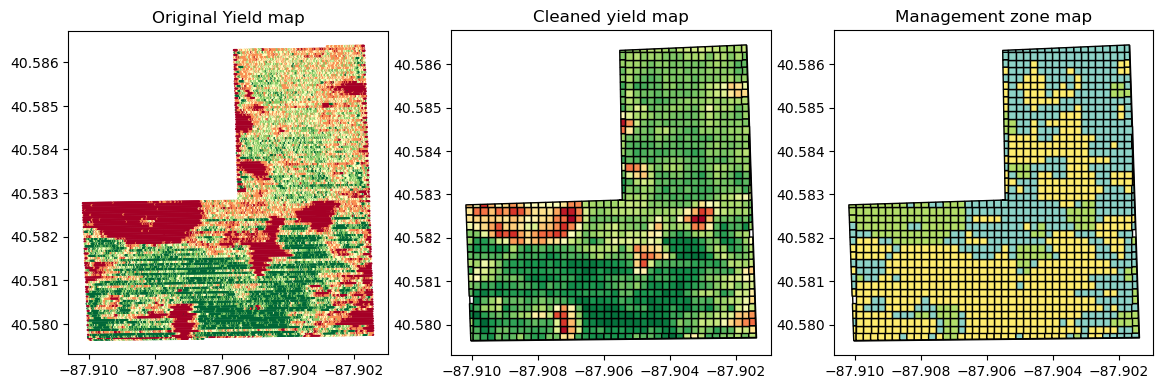

In [21]:
# Colors
original = '#a5a5a5'
out_col = '#6b0f1a'

# Create a figure and axes objects for two subplots
fig, ax = plt.subplots(1, 3, figsize=(14, 6))  # Adjust the figsize to fit your needs

## MAP 1  - original yield map##
df.plot(ax = ax[0],
        column = 'VRYIELDVOL',
        scheme = 'Quantiles',
        cmap = 'RdYlGn',  legend = False,
        marker = '.', markersize=2.5,
        legend_kwds={'loc': 'upper left'}) 
ax[0].set_title("Original Yield map")

## MAP 2  - Cleaned yield map##
boundary.plot(ax=ax[1], facecolor='w', edgecolor='k')
gdf_grid.plot(ax=ax[1], column='yield', edgecolor='k', cmap='RdYlGn')
ax[1].set_title("Cleaned yield map")


## MAP 3  - Management zone map ##
boundary.plot(ax=ax[2], facecolor='w', edgecolor='k')
gdf_grid.plot(ax=ax[2], column='zone', edgecolor='k', cmap='Set3')
ax[2].set_title("Management zone map")

ax[0].ticklabel_format(useOffset=False)
ax[1].ticklabel_format(useOffset=False)
ax[2].ticklabel_format(useOffset=False)

# Show the plot
plt.show()

## References

Bullock, D.S., Lowenberg‐DeBoer, J., Swinton, S.M., 2002. Adding value to spatially managed inputs by understanding site‐specific yield response. Agricultural Economics 27, 233–245. https://doi.org/10.1111/j.1574-0862.2002.tb00119.x

Khosla, R. and Flynn, B., 2008. Understanding and cleaning yield monitor data. Soil Science Step‐by‐Step Field Analysis, pp.113-130. https://doi.org/10.2136/2008.soilsciencestepbystep.c9